# Air quality comparison in Turin during 2020
Comparing Google mobility data with air quality data provided by regional autority (ARPA).

In [56]:
# libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statistics

## Mobility Dataset:

### Reading mobility data 
Provided by: <br>
Google LLC "Google COVID-19 Community Mobility Reports".
https://www.google.com/covid19/mobility/ 

In [74]:
path = 'data/Mobility/2020_IT_Region_Mobility_Report.csv'
palette = ["blue","red","green","orange","purple","brown"]
labels=['Retail & Recreation','Grocery & Pharmacy','Parks','Transit stations','Workplaces','Residential']
positions = ['retail_and_recreation_percent_change_from_baseline','grocery_and_pharmacy_percent_change_from_baseline','parks_percent_change_from_baseline','transit_stations_percent_change_from_baseline','workplaces_percent_change_from_baseline','residential_percent_change_from_baseline']

it_mobility_data = pd.read_csv(path, parse_dates=['date'])

### Filtering Data

In [73]:
#Filtering by sub_region
to_mobility_data = it_mobility_data[it_mobility_data['sub_region_2'] == 'Metropolitan City of Turin'].copy()
#remove empty column
to_mobility_data.dropna(how='all', axis=1, inplace=True)

### Multi-Line plot

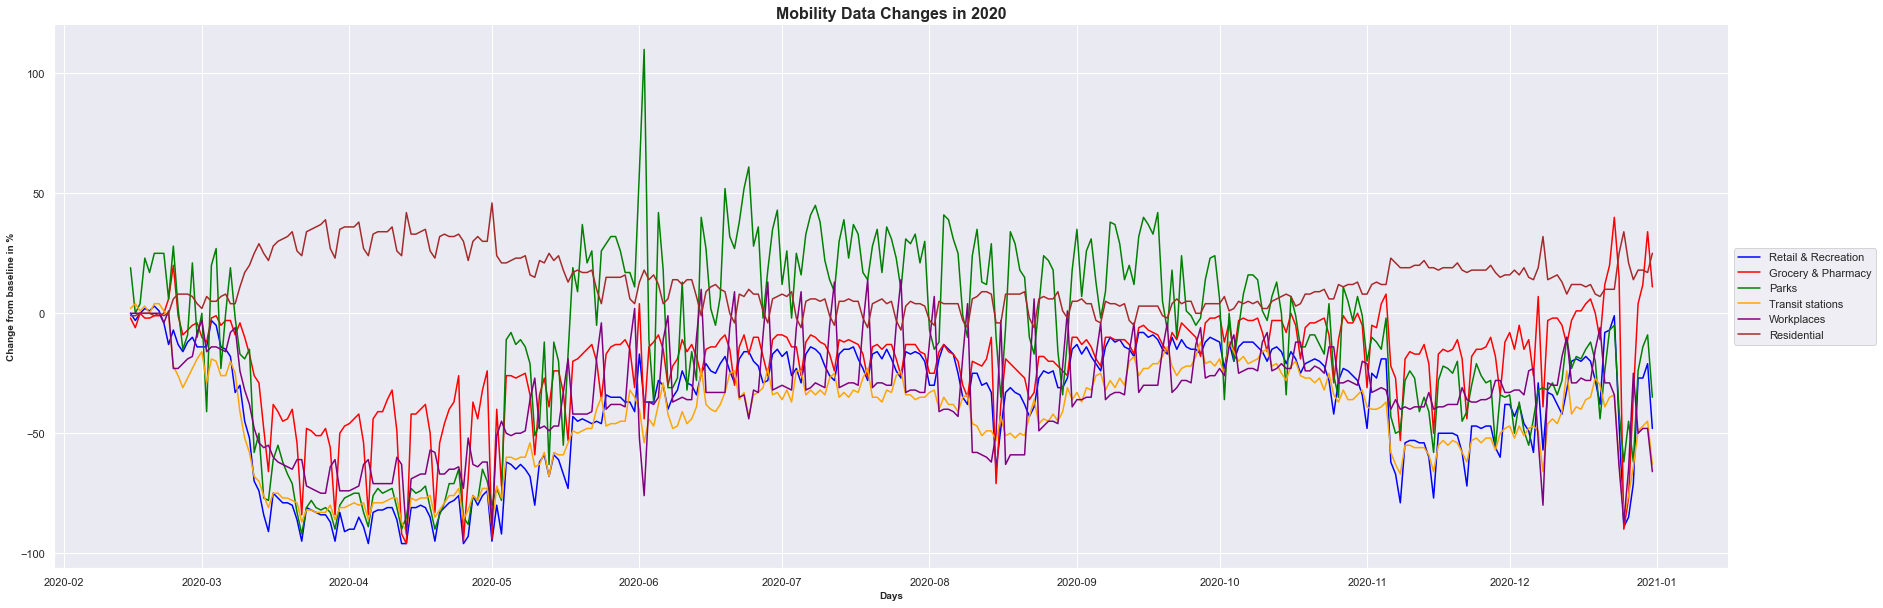

In [61]:
#set seaborn grapichs theme
sns.set_theme()

plt.figure(figsize=(30, 10))




# create a color palette
#palette = plt.get_cmap('Paired')

num = 0
plots =[]

for y in positions:
    line = to_mobility_data[y]
    p = plt.plot(to_mobility_data.date,line, label=labels[num], color=palette[num])
    plots += p
    num+=1

plt.xlabel('Days',fontdict= { 'fontsize': 10, 'fontweight':'bold'})
plt.ylabel('Change from baseline in %',fontdict= { 'fontsize': 10, 'fontweight':'bold'})
plt.legend(handles=plots)
plt.title("Mobility Data Changes in 2020",fontdict= { 'fontsize': 16, 'fontweight':'bold'})
ax = plt.gca()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(True)
sns.despine()
plt.show()

## Air Quality Dataset:

### Reading ARPA data 
Provided by: <br>
Arpa Piemonte <br>
Dipartimento Rischi naturali e ambientali <br>
https://aria.ambiente.piemonte.it/

In [75]:
def read_ARPA_csv(path):
    dataFrame = pd.read_csv(path, sep=';',dtype={'Data rilevamento': str, 'Ora':str},index_col=False ) 

    #merge date and hours and parsing
    dataFrame["Data rilevamento"] = dataFrame["Data rilevamento"] + " " +  dataFrame["Ora"]
    dataFrame["Data rilevamento"] = pd.to_datetime(dataFrame["Data rilevamento"]) 
    return dataFrame

def get_daily_adjusted_data(path):
    initial_data=read_ARPA_csv(path)
    #group by day
    data_daily = initial_data.resample('D', on='Data rilevamento').mean()
    #adjusting on baseline
    reference_period = initial_data[(initial_data['Data rilevamento'] >= '2020-01-03') & (initial_data['Data rilevamento'] < '2020-02-06')]
    basevalue = reference_period['Valore'].mean()
    adjusted_data = data_daily[(data_daily.index.get_level_values('Data rilevamento') >= '2020-02-15')]
    adjusted_data -= basevalue
    return adjusted_data   

### Merging both dataset

In [76]:
merged_data = to_mobility_data.merge(get_daily_adjusted_data('data/ARPA/Torino-Consolata_Gas_2020-01-01_2020-12-31.csv')[['Valore']], left_on='date', right_on='Data rilevamento')
merged_data

,country_region_code,country_region,sub_region_1,sub_region_2,iso_3166_2_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,Valore
0,IT,Italy,Piedmont,Metropolitan City of Turin,IT-TO,ChIJ_8Ubk5VFiEcRcH08R33mBQM,2020-02-15,0.0,-2.0,19.0,2.0,0.0,-1.0,19.537516
1,IT,Italy,Piedmont,Metropolitan City of Turin,IT-TO,ChIJ_8Ubk5VFiEcRcH08R33mBQM,2020-02-16,-3.0,-6.0,0.0,4.0,0.0,-1.0,-30.879150
2,IT,Italy,Piedmont,Metropolitan City of Turin,IT-TO,ChIJ_8Ubk5VFiEcRcH08R33mBQM,2020-02-17,0.0,0.0,4.0,1.0,0.0,0.0,-28.587484
3,IT,Italy,Piedmont,Metropolitan City of Turin,IT-TO,ChIJ_8Ubk5VFiEcRcH08R33mBQM,2020-02-18,2.0,-2.0,23.0,3.0,0.0,0.0,18.579183
4,IT,Italy,Piedmont,Metropolitan City of Turin,IT-TO,ChIJ_8Ubk5VFiEcRcH08R33mBQM,2020-02-19,1.0,-2.0,17.0,0.0,0.0,0.0,-27.170817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,IT,Italy,Piedmont,Metropolitan City of Turin,IT-TO,ChIJ_8Ubk5VFiEcRcH08R33mBQM,2020-12-27,-71.0,-34.0,-62.0,-64.0,-25.0,14.0,-72.337484
317,IT,Italy,Piedmont,Metropolitan City of Turin,IT-TO,ChIJ_8Ubk5VFiEcRcH08R33mBQM,2020-12-28,-27.0,4.0,-24.0,-49.0,-50.0,18.0,-60.504150
318,IT,Italy,Piedmont,Metropolitan City of Turin,IT-TO,ChIJ_8Ubk5VFiEcRcH08R33mBQM,2020-12-29,-27.0,12.0,-14.0,-47.0,-48.0,18.0,36.537516
319,IT,Italy,Piedmont,Metropolitan City of Turin,IT-TO,ChIJ_8Ubk5VFiEcRcH08R33mBQM,2020-12-30,-21.0,34.0,-9.0,-45.0,-48.0,17.0,6.620850


### Merged Lineplot

<AxesSubplot:>

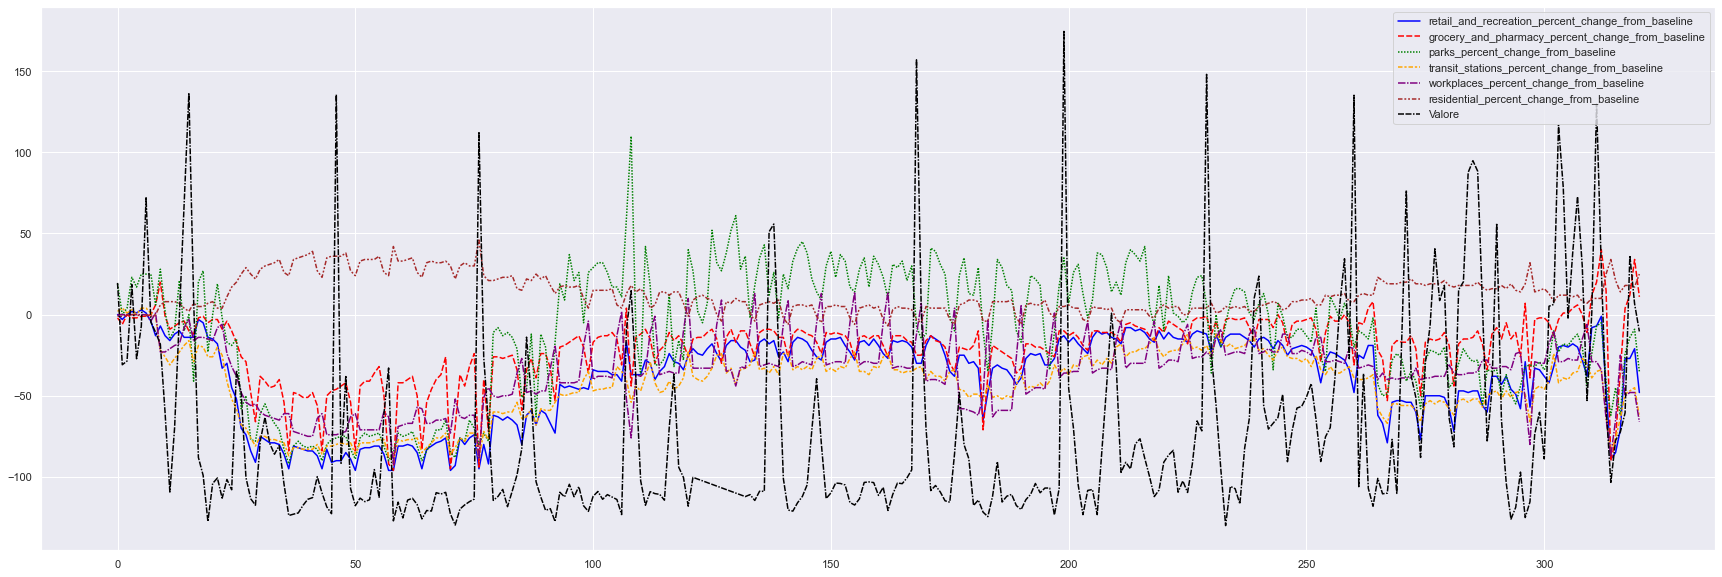

In [77]:
plt.figure(figsize=(30, 10))
palette.append("black")
sns.lineplot(data=merged_data, palette=palette)